<a href="https://colab.research.google.com/github/maratsmuk/Text_tickets_clustering/blob/main/Tickets_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Scientist, test task
## Candidate: Marat Mukhametzhanov
### Problem type: text clustering

## Table of contents
* [Introduction](#introduction)
* [Data Processing](#data)
* [Clustering](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)






##Introduction <a name="introduction"></a>
Problem setup: 
- The Client has thousands of events produced by his monitoring system every day. In our case, events are parsed and represented as strings.
- The Client wants to have a daily report with events summary. Tickets data for 1 day is provided in the form of a csv file (tickets.csv) in the test task archive. There is 1 column: ''ticket'', without an index.

Present Jupyter Notebook has the following functionality:
- Basic data analysis, visualisation.
- Clustering. Results evaluation and analysis.
- Summary of tickets in compact form (say, you need to include it in the report

Used language: Python

##Data Processing <a name="data"></a>

**Step 0:** Importing necessary libraries:

- Pandas for working with data
- re for purifying the text using regular expressions 
- sklearn.feature_extraction.text.TfidfVectorizer for feature transformation
- numpy for working with numerical features
- sklearn for machine learning purposes
- wordcloud and matplotlib for visualizations

In [ ]:
import numpy as np
import pandas as pd
import re
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 255)

**Step 1:** First insights on data
One can see that each record consists of the device ID (written in the first part of the tickets right before the first ":") and the message. 

In [ ]:
df = pd.read_csv('tickets.csv')
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5446 entries, 0 to 5445
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ticket  5446 non-null   object
dtypes: object(1)
memory usage: 42.7+ KB


,ticket
0,eit-prismadm01.tgna.tegna.com: System or agent has recently restarted
1,"ATL-NELLC-N9K-2: Interface state changed to operationally down: 436212736, Name: Ethernet1/11 P950-3_C6-1; previous state was up (1)"
2,vaqupdtoms01: Device Failed Availability Check: UDP - SNMP
3,"test-vm-01: VMware: VM CPU Usage Has Exceeded Threshold (95%), currently (100.0%)"
4,NTNX-local-ds-19SM6J290326-B: Device Failed Availability Check: Component device 9872 is not available (NTNX-local-ds-19SM6J290326-B); Reason: Availability App


**Step 2:** Data preparation. It can be useful to purify the tickets separating the device IDs with the main messages. After that, the messages are also purified from the details (e.g., numbers, ip addresses, concrete percentages, etc.). Some ambiguous terms are transformed into non-ambiguous ones (e.g., "file system" is transformed to "filesystem", "%" -> "percent", etc.). 

In [ ]:
def elaborateString(s):
  ID = ''
  MSG = ''
  x = s.split(': ')
  if len(x)==1:
    ID = ''
    MSG = s
  else:
    ID = x[0]
    MSG = ': '.join(x[1:])
    MSG = MSG.lower()
  MSG = re.sub(r'threshold.*','threshold',MSG)
  MSG = re.sub(r'down.*','down',MSG)
  MSG = re.sub(r'check.*','check',MSG)
  MSG = re.sub(r'running.*','running',MSG)
  MSG = re.sub(r'file system','filesystem',MSG)
  MSG = re.sub(r'\[.*?\]','',MSG)
  MSG = re.sub(r'\'.*?\' ', '', MSG)
  MSG = re.sub(r'\(.*?\) ','',MSG)  
  MSG = re.sub(r'of [[0-9]+\.?[0-9]*|\.[0-9]+] ','',MSG)
  MSG = re.sub(r'[[0-9]+\.?[0-9]*|\.[0-9]+] ','',MSG)
  MSG = re.sub(r'[A-z]:\\:','',MSG)
  MSG = re.sub('[A-z]+\-[A-z]+\_[A-z]+: ','',MSG)
  MSG = re.sub('%',' percent ',MSG)
  MSG = re.sub(':','',MSG)
  #MSG = re.sub('%','',MSG)
  #MSG = re.sub('percent','',MSG)
  #MSG = re.sub('required','',MSG)
  MSG = re.sub('vmware','',MSG)
  MSG = re.sub('vm','',MSG)
  MSG = re.sub('host','',MSG)
  MSG = re.sub('usage','',MSG)
  MSG = re.sub('resource','',MSG)
  return ID,MSG

In [ ]:
IDs = []
Titles = []
MSGs = []
x = df['ticket'].tolist()
for t in x:
  id,msg = elaborateString(t)
  IDs.append(id)
  MSGs.append(msg)
df['deviceID'] = IDs
df['eventMSG'] = MSGs
#df.drop(columns=['deviceID','ticket'],inplace=True)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Possible nested set at position 4
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Possible nested set at position 1


,ticket,deviceID,eventMSG
0,eit-prismadm01.tgna.tegna.com: System or agent has recently restarted,eit-prismadm01.tgna.tegna.com,system or agent has recently restarted
1,"ATL-NELLC-N9K-2: Interface state changed to operationally down: 436212736, Name: Ethernet1/11 P950-3_C6-1; previous state was up (1)",ATL-NELLC-N9K-2,interface state changed to operationally down
2,vaqupdtoms01: Device Failed Availability Check: UDP - SNMP,vaqupdtoms01,device failed availability check
3,"test-vm-01: VMware: VM CPU Usage Has Exceeded Threshold (95%), currently (100.0%)",test-vm-01,cpu has exceeded threshold
4,NTNX-local-ds-19SM6J290326-B: Device Failed Availability Check: Component device 9872 is not available (NTNX-local-ds-19SM6J290326-B); Reason: Availability App,NTNX-local-ds-19SM6J290326-B,device failed availability check


**Step 3:** Data visualization. 
Let us visuailze now our tickets graphically using WordCloud.

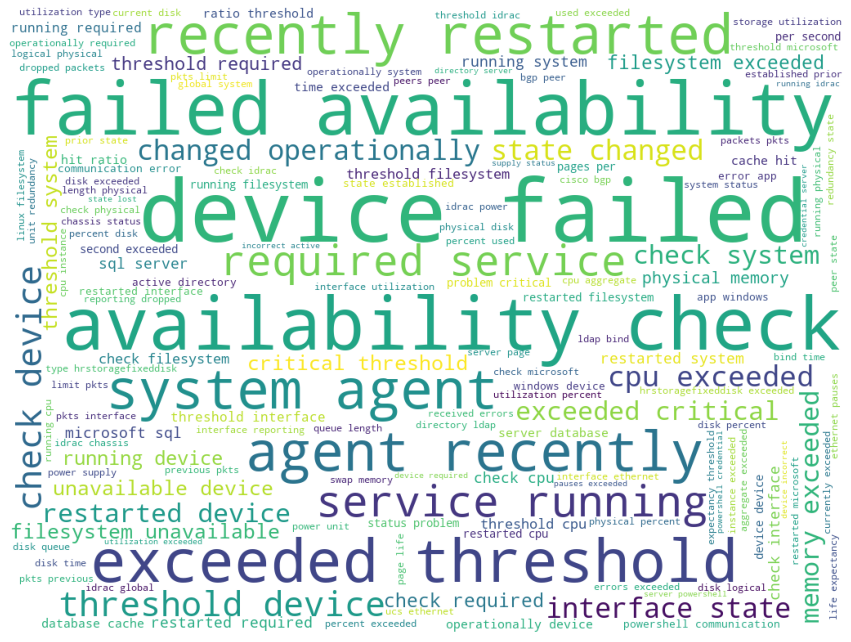

In [ ]:

msg_text = ' '.join(df['eventMSG'])
stopwords = set(STOPWORDS)
wcloud = WordCloud(width = 1024, height = 768,background_color ='white',stopwords = stopwords,min_font_size = 10).generate(msg_text)
# Generate plot
plt.figure(figsize=(15,15))
plt.imshow(wcloud)
plt.axis("off")
plt.show()

**Step 4:** Feature engineering. Let us use the Tf-Idf method to transform our textual data into numerical one.

In [ ]:
vectorizer = TfidfVectorizer(max_df=1).fit(df['eventMSG'])
stop_names = list(vectorizer.get_feature_names())
vectorizer = TfidfVectorizer(min_df = 0.01,stop_words=stop_names+['and','on','has','is','or','the','to','per'])
words = vectorizer.fit_transform(df['eventMSG'])
X = words.toarray().tolist()
print('Number of samples:',len(X))
print('Number of features:',len(X[0]))
#print(len(X),len(X[0]))
vectorizer.get_feature_names()
X_np = np.array(X)

Number of samples: 5446
Number of features: 50


##Clustering <a name="methodology"></a>

Let us try three different clustering methods: KMeans, DBSCAN and Hierarchical clustering. The first method (KMeans) has only one main control parameter: the value ``k'' of the clusters. In order to choose it correctly, let us use the Elbow method:

170.17345119602345
[4498.301986766433, 3222.860025574115, 2437.3459979806257, 1878.310477221526, 1470.7515779127548, 1218.789921417325, 1022.7095028868468, 881.5894796295684, 743.2694717279655, 656.055016141146, 577.877166124837, 508.43533136481653, 452.6450086311772, 402.58521780604053, 354.81530523312955, 310.2781046202285, 263.48249064155647, 228.8553098174386, 200.19340756023092, 170.17345119602345]


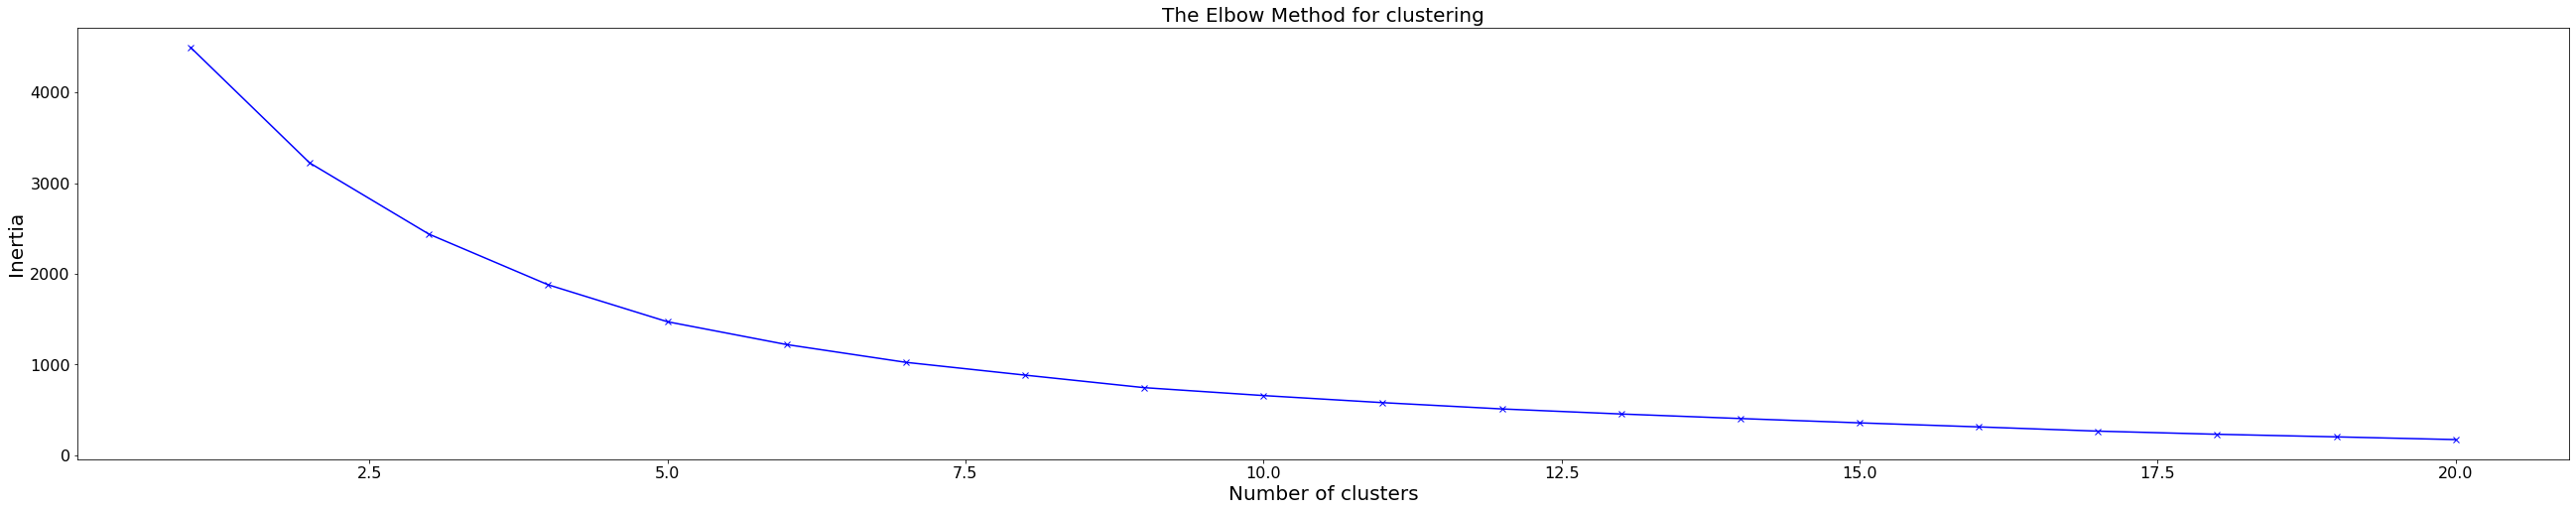

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(45,8))
kmeans_list_inertia = []
kmax = min(21,len(X[0])+1)
for k in range(1,kmax):
  #print(k)
  kmeans = KMeans(n_clusters=k, random_state=1).fit(X_np)
  kmeans_list_inertia.append(kmeans.inertia_)
  #kmeans.labels_
axs.plot(range(1,kmax), kmeans_list_inertia, 'bx-')
axs.set_title('The Elbow Method for clustering',fontsize=20)
axs.set_xlabel('Number of clusters', fontsize=20)
axs.set_ylabel('Inertia', fontsize=20)
axs.tick_params(labelsize=16)
print(min(kmeans_list_inertia))
print(kmeans_list_inertia)

In [ ]:
kmeans = KMeans(n_clusters=15, random_state=1).fit(X_np)

DBSCAN method has two control parameters: the radius alfa (set to 0.5 by default) and the minimal number of points N to define the cluster. Too small N leads to overfitting, while too large values of N lead to underfitting.  

In [ ]:
dbscan = DBSCAN(0.5,100).fit(X_np)
dbscan.labels_

array([ 0,  1,  2, ..., -1,  0,  4])

Hierarchical clustering has also only one main control parameter: the number of clusters k. Different values have been tried: for k>17, there are created clusters with too small number of elements (less than 10), so the largest reasonable value of the number of clusters is 17 (when there are no clusters with less than 20 elements). 

In [ ]:
model_agg = AgglomerativeClustering(n_clusters=15,linkage="average").fit(X_np)

In [ ]:
labels_db = dbscan.labels_
labels_km = kmeans.labels_
labels_ac = model_agg.labels_
print(len(list(set(labels_db))))
print(len(list(set(labels_km))))
print(len(list(set(labels_ac))))

9
15
15


##Results <a name="results"></a>

Let us study the scores of the methods on our training set:

In [ ]:
print('DBSCAN:',metrics.silhouette_score(X_np, labels_db, metric='euclidean'))
print('KMeans:',metrics.silhouette_score(X_np, labels_km, metric='euclidean'))
print('Hierarchical clustering:',metrics.silhouette_score(X_np, labels_ac, metric='euclidean'))

DBSCAN: 0.7757503926724064
KMeans: 0.8716456826032777
Hierarchical clustering: 0.8044015470620792


Add the obtained labels to our dataframe in order to study the results.

In [ ]:
df['cluster_db'] = list(labels_db)
df['cluster_km'] = list(labels_km)
df['cluster_ac'] = list(labels_ac)
df.head()

,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
0,eit-prismadm01.tgna.tegna.com: System or agent has recently restarted,eit-prismadm01.tgna.tegna.com,system or agent has recently restarted,0,2,7
1,"ATL-NELLC-N9K-2: Interface state changed to operationally down: 436212736, Name: Ethernet1/11 P950-3_C6-1; previous state was up (1)",ATL-NELLC-N9K-2,interface state changed to operationally down,1,4,0
2,vaqupdtoms01: Device Failed Availability Check: UDP - SNMP,vaqupdtoms01,device failed availability check,2,0,8
3,"test-vm-01: VMware: VM CPU Usage Has Exceeded Threshold (95%), currently (100.0%)",test-vm-01,cpu has exceeded threshold,3,6,5
4,NTNX-local-ds-19SM6J290326-B: Device Failed Availability Check: Component device 9872 is not available (NTNX-local-ds-19SM6J290326-B); Reason: Availability App,NTNX-local-ds-19SM6J290326-B,device failed availability check,2,0,8


Let us study the obtained clusters

In [ ]:
df.groupby("cluster_km").describe()

cluster_db                           ... cluster_ac                  
                count      mean       std  min  ...        25%   50%   75%   max
cluster_km                                      ...                             
0              1589.0  1.998112  0.075259 -1.0  ...        8.0   8.0   8.0   8.0
1               752.0  3.640957  1.291712 -1.0  ...        4.0   4.0   4.0   4.0
2               860.0  0.000000  0.000000  0.0  ...        7.0   7.0   7.0   7.0
3               150.0 -1.000000  0.000000 -1.0  ...        5.0   5.0   6.0  14.0
4               310.0  0.774194  0.633972 -1.0  ...        0.0   0.0   0.0  12.0
5               235.0  4.361702  1.853912 -1.0  ...        5.0   5.0   5.0   5.0
6               424.0  2.415094  1.415002 -1.0  ...        5.0   5.0   5.0  14.0
7               242.0  5.913223  0.776142 -1.0  ...        3.0   3.0   3.0   3.0
8               254.0  3.787402  3.929477 -1.0  ...        5.0   5.0   5.0   5.0
9               132.0 -1.000000  0.000000 -1.0  ...        1.0   1.0   1.0   1.0
10              119.0 -1.000000  0.000000 -1.0  ...        9.0   9.0   9.0   9.0
11              114.0 -1.000000  0.000000 -1.0  ...        2.0   2.0   2.0  12.0
12               59.0 -1.000000  0.000000 -1.0  ...       13.0  13.0  13.0  13.0
13              139.0 -1.000000  0.000000 -1.0  ...        6.0  14.0  14.0  14.0
14               67.0 -1.000000  0.000000 -1.0  ...       10.0  10.0  10.0  10.0

[15 rows x 16 columns]

In [ ]:
df.groupby("cluster_db").describe()

cluster_km                                ... cluster_ac                      
                count      mean       std  min  25%  ...        min  25%  50%   75%   max
cluster_db                                           ...                                 
-1             1062.0  8.533898  3.841619  0.0  6.0  ...        0.0  3.0  5.0  11.0  14.0
 0              860.0  2.000000  0.000000  2.0  2.0  ...        7.0  7.0  7.0   7.0   7.0
 1              275.0  4.000000  0.000000  4.0  4.0  ...        0.0  0.0  0.0   0.0   0.0
 2             1588.0  0.000000  0.000000  0.0  0.0  ...        8.0  8.0  8.0   8.0   8.0
 3              362.0  6.000000  0.000000  6.0  6.0  ...        5.0  5.0  5.0   5.0   5.0
 4              698.0  1.000000  0.000000  1.0  1.0  ...        4.0  4.0  4.0   4.0   4.0
 5              210.0  5.000000  0.000000  5.0  5.0  ...        5.0  5.0  5.0   5.0   5.0
 6              239.0  7.000000  0.000000  7.0  7.0  ...        3.0  3.0  3.0   3.0   3.0
 7              152.0  8.000000  0.000000  8.0  8.0  ...        5.0  5.0  5.0   5.0   5.0

[9 rows x 16 columns]

In [ ]:
df.groupby("cluster_ac").describe()

cluster_db                           ... cluster_km                  
                count      mean       std  min  ...        25%   50%   75%   max
cluster_ac                                      ...                             
0               314.0  0.751592  0.660681 -1.0  ...        4.0   4.0   4.0  13.0
1               137.0 -1.000000  0.000000 -1.0  ...        9.0   9.0   9.0   9.0
2                88.0 -1.000000  0.000000 -1.0  ...       11.0  11.0  11.0  11.0
3               242.0  5.913223  0.776142 -1.0  ...        7.0   7.0   7.0   7.0
4               752.0  3.640957  1.291712 -1.0  ...        1.0   1.0   1.0   1.0
5               939.0  3.178914  2.669008 -1.0  ...        5.0   6.0   8.0   8.0
6                67.0 -1.000000  0.000000 -1.0  ...        3.0   3.0  13.0  13.0
7               860.0  0.000000  0.000000  0.0  ...        2.0   2.0   2.0   2.0
8              1589.0  1.998112  0.075259 -1.0  ...        0.0   0.0   0.0   0.0
9               119.0 -1.000000  0.000000 -1.0  ...       10.0  10.0  10.0  10.0
10               67.0 -1.000000  0.000000 -1.0  ...       14.0  14.0  14.0  14.0
11               58.0 -1.000000  0.000000 -1.0  ...        6.0   6.0   6.0   6.0
12               54.0 -1.000000  0.000000 -1.0  ...        4.0   4.0  11.0  11.0
13               59.0 -1.000000  0.000000 -1.0  ...       12.0  12.0  12.0  12.0
14              101.0 -1.000000  0.000000 -1.0  ...       13.0  13.0  13.0  13.0

[15 rows x 16 columns]

In [ ]:
for i in range(max(labels_km)+1):
  display(df[df['cluster_km']==i].head(3))

,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
2,vaqupdtoms01: Device Failed Availability Check: UDP - SNMP,vaqupdtoms01,device failed availability check,2,0,8
4,NTNX-local-ds-19SM6J290326-B: Device Failed Availability Check: Component device 9872 is not available (NTNX-local-ds-19SM6J290326-B); Reason: Availability App,NTNX-local-ds-19SM6J290326-B,device failed availability check,2,0,8
5,IntegrateStaging: Device Failed Availability Check: Component device 18416 is not available ; Reason: At least one ancestor of IntegrateStaging (ID=> 18416) has,IntegrateStaging,device failed availability check,2,0,8


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
6,iad01vm22-04: Required service not running: Tomcat7,iad01vm22-04,required service not running,4,1,4
19,iad1-p04-p-ap08: Required service not running: Tax Calculator,iad1-p04-p-ap08,required service not running,4,1,4
41,iad1-p04-p-ap09: Required service not running: Tomcat7,iad1-p04-p-ap09,required service not running,4,1,4


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
0,eit-prismadm01.tgna.tegna.com: System or agent has recently restarted,eit-prismadm01.tgna.tegna.com,system or agent has recently restarted,0,2,7
8,etm-priwomsrd05.tgna.tegna.com: System or agent has recently restarted,etm-priwomsrd05.tgna.tegna.com,system or agent has recently restarted,0,2,7
10,etm-prictxvda01.tgna.tegna.com: System or agent has recently restarted,etm-prictxvda01.tgna.tegna.com,system or agent has recently restarted,0,2,7


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
17,sys/chassis-1/slot-2: UCS: Ethernet Pauses has exceeded threshold (10 Pauses) currently (18.0 Pauses),sys/chassis-1/slot-2,ucs ethernet pauses has exceeded threshold,-1,3,5
25,"iad2-tegna-dmvpn2.tgna.tegna.com: IPSLA: [302] WCNC-UW01_ZAYO: Packet Loss Above minor threshold 2.5%, currently 2.6%",iad2-tegna-dmvpn2.tgna.tegna.com,ipsla packet loss above minor threshold,-1,3,11
152,"iad01vh23: Bandwidth usage exceeded threshold: 1784.54202419 %, limit: 90.000 %, previous: 5.36028671015 %, Interface: PublicVLAN682 Public, Direction: Inbound",iad01vh23,bandwidth exceeded threshold,-1,3,5


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
1,"ATL-NELLC-N9K-2: Interface state changed to operationally down: 436212736, Name: Ethernet1/11 P950-3_C6-1; previous state was up (1)",ATL-NELLC-N9K-2,interface state changed to operationally down,1,4,0
12,DFW1-TEGNA-DMVPN1.tgna.tegna.com: Cisco: BGP Peers (216.200.132.68) Peer state is not established and Prior state was established,DFW1-TEGNA-DMVPN1.tgna.tegna.com,cisco bgp peers peer state is not established and prior state was established,-1,4,12
18,"eit-prisqldb01.tgna.tegna.com: Interface state changed to operationally down: 4, Name: tunnel_32770 Local Area Connection* 2; previous state was up (1)",eit-prisqldb01.tgna.tegna.com,interface state changed to operationally down,1,4,0


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
13,"nysjcyaixdb01: /dev/data_u_lv: File system usage exceeded critical threshold: Limit: 94.0%, Actual: 95.36%",nysjcyaixdb01,/dev/data_u_lv filesystem exceeded critical threshold,5,5,5
81,"pmusweb11.PMUS.local: F:\: File system usage exceeded critical threshold: Limit: 93.0%, Actual: 93.30%",pmusweb11.PMUS.local,filesystem exceeded critical threshold,5,5,5
94,"iad01vm27-04: D:\: File system usage exceeded critical threshold: Limit: 80.0%, Actual: 80.00%",iad01vm27-04,filesystem exceeded critical threshold,5,5,5


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
3,"test-vm-01: VMware: VM CPU Usage Has Exceeded Threshold (95%), currently (100.0%)",test-vm-01,cpu has exceeded threshold,3,6,5
9,iad1-p03-p-mw09: Host Resource: CPU has exceeded threshold 90%. The current value is 95.0%.,iad1-p03-p-mw09,cpu has exceeded threshold,3,6,5
11,DCWRK04F004.hsftdc.local: Host Resource: CPU has exceeded threshold 90%. The current value is 99.0%.,DCWRK04F004.hsftdc.local,cpu has exceeded threshold,3,6,5


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
16,db48.qa.nec.com: Filesystem unavailable: '/dev/fslv01' on Device '2462',db48.qa.nec.com,filesystem unavailable on device '',6,7,3
40,nysjcyaixapp01: Filesystem unavailable: '/dev/hd1' on Device '2541',nysjcyaixapp01,filesystem unavailable on device '',6,7,3
117,Howl2012b.xdxinc.net: Filesystem unavailable: 'C:\' on Device '5847',Howl2012b.xdxinc.net,filesystem unavailable on device '',6,7,3


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
32,CONJCYVMWAD01.controltec.local: Host Resource: Physical Memory has exceeded threshold 90%. The current value is 95%.,CONJCYVMWAD01.controltec.local,physical memory has exceeded threshold,7,8,5
42,AD-FRANKFURT-2.syniti-cloud.lcl: Available Memory is below the threshold 256 MB. Current value is 143.0 MB.,AD-FRANKFURT-2.syniti-cloud.lcl,available memory is below the threshold,-1,8,1
56,"VAQUVAPNJS51: VMware: VM Memory Usage Has Exceeded Threshold (93%), currently (95.99%)",VAQUVAPNJS51,memory has exceeded threshold,-1,8,5


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
51,ocoptispray: Microsoft: SQL Server Database Cache Hit Ratio of 59.15 is below threshold 80 %.,ocoptispray,microsoft sql server database cache hit ratio is below threshold,-1,9,1
63,sdbc1_ecp_helsinki_filtered: Microsoft: SQL Server Database Cache Hit Ratio of 78.33 is below threshold 80 %.,sdbc1_ecp_helsinki_filtered,microsoft sql server database cache hit ratio is below threshold,-1,9,1
69,ektroofingdb: Microsoft: SQL Server Database Cache Hit Ratio of 57.78 is below threshold 80 %.,ektroofingdb,microsoft sql server database cache hit ratio is below threshold,-1,9,1


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
101,URCATLWDB02: Disk _Total Logical Physical Percent Disk Time has exceeded threshold: (70%) currently (100%),URCATLWDB02,disk _total logical physical percent disk time has exceeded threshold,-1,10,9
169,bausch-db: The % Disk Used for logical disk (G) has exceeded the threshold 90%.,bausch-db,the percent disk used for logical disk has exceeded the threshold,-1,10,9
193,dxc-db: The Current Disk Queue Length for physical disk (TOTAL) has exceeded the threshold 90 Requests.,dxc-db,the current disk queue length for physical disk has exceeded the threshold,-1,10,9


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
73,360iadesx10: iDRAC Power Supply Status Problem: Critical,360iadesx10,idrac power supply status problem critical,-1,11,2
98,aberdeen-esx03: iDRAC Power Unit Problem: Critical,aberdeen-esx03,idrac power unit problem critical,-1,11,2
189,aberdeen-esx05: iDRAC Power Supply Status Problem: Critical,aberdeen-esx05,idrac power supply status problem critical,-1,11,2


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
38,dxc-app: PowerShell Communication Error: App [1879] Windows device [172.20.0.2]:,dxc-app,powershell communication error app windows device,-1,12,13
222,becton-app: PowerShell Communication Error: App [327] Windows device [172.20.0.26]: Server connection timed out. The device cannot respond to WinRM requests or,becton-app,powershell communication error app windows device server connection timed out. the device cannot respond to winrm requests or,-1,12,13
333,ezaki-db: PowerShell Communication Error: App [1880] Windows device [172.20.96.19]:,ezaki-db,powershell communication error app windows device,-1,12,13


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
74,EIT-MOCEXHYB02.tgna.tegna.com: Host Resource: Storage Utilization (C:\\ Label: Serial Number be0ee50e) of type HrStorageFixedDisk has exceeded critical thresho,EIT-MOCEXHYB02.tgna.tegna.com,storage utilization of type hrstoragefixeddisk has exceeded critical thresho,-1,13,14
89,proddb1.local.Aberdeen.com: Host Resource: Storage Utilization (D:\\ Label: Serial Number 6efe0da) of type HrStorageFixedDisk has exceeded critical threshold 9,proddb1.local.Aberdeen.com,storage utilization of type hrstoragefixeddisk has exceeded critical threshold,-1,13,14
134,iad1-p02-p-db03: Host Resource: Storage Utilization (H:\\ Label:Read Data Serial Number dcfde9c9) of type HrStorageFixedDisk has exceeded critical threshold 90,iad1-p02-p-db03,storage utilization of type hrstoragefixeddisk has exceeded critical threshold,-1,13,14


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
170,10.224.50.36: Pages per Second has exceeded the threshold 200 Pages/Second. The value is currently 287 Pages/Second.,10.224.50.36,pages per second has exceeded the threshold,-1,14,10
362,URCATLVMWSUS01: Pages per Second has exceeded the threshold 200 Pages/Second. The value is currently 4259 Pages/Second.,URCATLVMWSUS01,pages per second has exceeded the threshold,-1,14,10
369,dxc-db: Pages per Second has exceeded the threshold 500 Pages/Second. Current value is 31272.55 Pages/Second.,dxc-db,pages per second has exceeded the threshold,-1,14,10


In [ ]:
for i in range(max(labels_ac)+1):
  display(df[df['cluster_ac']==i].head(3))

,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
1,"ATL-NELLC-N9K-2: Interface state changed to operationally down: 436212736, Name: Ethernet1/11 P950-3_C6-1; previous state was up (1)",ATL-NELLC-N9K-2,interface state changed to operationally down,1,4,0
18,"eit-prisqldb01.tgna.tegna.com: Interface state changed to operationally down: 4, Name: tunnel_32770 Local Area Connection* 2; previous state was up (1)",eit-prisqldb01.tgna.tegna.com,interface state changed to operationally down,1,4,0
22,"VAQUVAPDTC03: Interface state changed to operationally down: 415, Name: br-158d83927c5b br-158d83927c5b; previous state was up (1)",VAQUVAPDTC03,interface state changed to operationally down,1,4,0


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
42,AD-FRANKFURT-2.syniti-cloud.lcl: Available Memory is below the threshold 256 MB. Current value is 143.0 MB.,AD-FRANKFURT-2.syniti-cloud.lcl,available memory is below the threshold,-1,8,1
51,ocoptispray: Microsoft: SQL Server Database Cache Hit Ratio of 59.15 is below threshold 80 %.,ocoptispray,microsoft sql server database cache hit ratio is below threshold,-1,9,1
63,sdbc1_ecp_helsinki_filtered: Microsoft: SQL Server Database Cache Hit Ratio of 78.33 is below threshold 80 %.,sdbc1_ecp_helsinki_filtered,microsoft sql server database cache hit ratio is below threshold,-1,9,1


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
73,360iadesx10: iDRAC Power Supply Status Problem: Critical,360iadesx10,idrac power supply status problem critical,-1,11,2
98,aberdeen-esx03: iDRAC Power Unit Problem: Critical,aberdeen-esx03,idrac power unit problem critical,-1,11,2
189,aberdeen-esx05: iDRAC Power Supply Status Problem: Critical,aberdeen-esx05,idrac power supply status problem critical,-1,11,2


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
16,db48.qa.nec.com: Filesystem unavailable: '/dev/fslv01' on Device '2462',db48.qa.nec.com,filesystem unavailable on device '',6,7,3
40,nysjcyaixapp01: Filesystem unavailable: '/dev/hd1' on Device '2541',nysjcyaixapp01,filesystem unavailable on device '',6,7,3
117,Howl2012b.xdxinc.net: Filesystem unavailable: 'C:\' on Device '5847',Howl2012b.xdxinc.net,filesystem unavailable on device '',6,7,3


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
6,iad01vm22-04: Required service not running: Tomcat7,iad01vm22-04,required service not running,4,1,4
19,iad1-p04-p-ap08: Required service not running: Tax Calculator,iad1-p04-p-ap08,required service not running,4,1,4
41,iad1-p04-p-ap09: Required service not running: Tomcat7,iad1-p04-p-ap09,required service not running,4,1,4


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
3,"test-vm-01: VMware: VM CPU Usage Has Exceeded Threshold (95%), currently (100.0%)",test-vm-01,cpu has exceeded threshold,3,6,5
9,iad1-p03-p-mw09: Host Resource: CPU has exceeded threshold 90%. The current value is 95.0%.,iad1-p03-p-mw09,cpu has exceeded threshold,3,6,5
11,DCWRK04F004.hsftdc.local: Host Resource: CPU has exceeded threshold 90%. The current value is 99.0%.,DCWRK04F004.hsftdc.local,cpu has exceeded threshold,3,6,5


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
317,URGentCare-3750-SW01-ATL1.URGentCare-3750-SW01-ATL1: Trap Received: linkDown | Trap Detail: Interface: Gi2/0/2; ifIndex10602: 10602; ifDescr10602: GigabitEthern,URGentCare-3750-SW01-ATL1.URGentCare-3750-SW01-ATL1,trap received linkdown,-1,13,6
425,phx-p04-p-sw1: Juniper: FRU Routing Engine 2 is empty.,phx-p04-p-sw1,juniper fru routing engine is empty.,-1,13,6
489,ad-aus-1: Active Directory (ntds) LDAP Bind Time exceeded the threshold (3 ms).,ad-aus-1,active directory ldap bind time exceeded the threshold,-1,3,6


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
0,eit-prismadm01.tgna.tegna.com: System or agent has recently restarted,eit-prismadm01.tgna.tegna.com,system or agent has recently restarted,0,2,7
8,etm-priwomsrd05.tgna.tegna.com: System or agent has recently restarted,etm-priwomsrd05.tgna.tegna.com,system or agent has recently restarted,0,2,7
10,etm-prictxvda01.tgna.tegna.com: System or agent has recently restarted,etm-prictxvda01.tgna.tegna.com,system or agent has recently restarted,0,2,7


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
2,vaqupdtoms01: Device Failed Availability Check: UDP - SNMP,vaqupdtoms01,device failed availability check,2,0,8
4,NTNX-local-ds-19SM6J290326-B: Device Failed Availability Check: Component device 9872 is not available (NTNX-local-ds-19SM6J290326-B); Reason: Availability App,NTNX-local-ds-19SM6J290326-B,device failed availability check,2,0,8
5,IntegrateStaging: Device Failed Availability Check: Component device 18416 is not available ; Reason: At least one ancestor of IntegrateStaging (ID=> 18416) has,IntegrateStaging,device failed availability check,2,0,8


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
101,URCATLWDB02: Disk _Total Logical Physical Percent Disk Time has exceeded threshold: (70%) currently (100%),URCATLWDB02,disk _total logical physical percent disk time has exceeded threshold,-1,10,9
169,bausch-db: The % Disk Used for logical disk (G) has exceeded the threshold 90%.,bausch-db,the percent disk used for logical disk has exceeded the threshold,-1,10,9
193,dxc-db: The Current Disk Queue Length for physical disk (TOTAL) has exceeded the threshold 90 Requests.,dxc-db,the current disk queue length for physical disk has exceeded the threshold,-1,10,9


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
170,10.224.50.36: Pages per Second has exceeded the threshold 200 Pages/Second. The value is currently 287 Pages/Second.,10.224.50.36,pages per second has exceeded the threshold,-1,14,10
362,URCATLVMWSUS01: Pages per Second has exceeded the threshold 200 Pages/Second. The value is currently 4259 Pages/Second.,URCATLVMWSUS01,pages per second has exceeded the threshold,-1,14,10
369,dxc-db: Pages per Second has exceeded the threshold 500 Pages/Second. Current value is 31272.55 Pages/Second.,dxc-db,pages per second has exceeded the threshold,-1,14,10


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
25,"iad2-tegna-dmvpn2.tgna.tegna.com: IPSLA: [302] WCNC-UW01_ZAYO: Packet Loss Above minor threshold 2.5%, currently 2.6%",iad2-tegna-dmvpn2.tgna.tegna.com,ipsla packet loss above minor threshold,-1,3,11
244,VAQUVAPSPL22: CPU usage of 81.785794227 is above threshold of 80,VAQUVAPSPL22,cpu is above threshold,-1,6,11
259,vaquvatcom68: CPU usage of 84.2078615357 is above threshold of 80,vaquvatcom68,cpu is above threshold,-1,6,11


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
12,DFW1-TEGNA-DMVPN1.tgna.tegna.com: Cisco: BGP Peers (216.200.132.68) Peer state is not established and Prior state was established,DFW1-TEGNA-DMVPN1.tgna.tegna.com,cisco bgp peers peer state is not established and prior state was established,-1,4,12
119,DFW1-TEGNA-DMVPN2.tgna.tegna.com: Cisco: BGP Peers (172.17.105.73) Peer state is not established and Prior state was established,DFW1-TEGNA-DMVPN2.tgna.tegna.com,cisco bgp peers peer state is not established and prior state was established,-1,4,12
352,cons-mi-03-ba.lumin.digital: Cisco: BGP Peers (172.27.0.1) Peer state is not established and Prior state was established,cons-mi-03-ba.lumin.digital,cisco bgp peers peer state is not established and prior state was established,-1,4,12


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
38,dxc-app: PowerShell Communication Error: App [1879] Windows device [172.20.0.2]:,dxc-app,powershell communication error app windows device,-1,12,13
222,becton-app: PowerShell Communication Error: App [327] Windows device [172.20.0.26]: Server connection timed out. The device cannot respond to WinRM requests or,becton-app,powershell communication error app windows device server connection timed out. the device cannot respond to winrm requests or,-1,12,13
333,ezaki-db: PowerShell Communication Error: App [1880] Windows device [172.20.96.19]:,ezaki-db,powershell communication error app windows device,-1,12,13


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
74,EIT-MOCEXHYB02.tgna.tegna.com: Host Resource: Storage Utilization (C:\\ Label: Serial Number be0ee50e) of type HrStorageFixedDisk has exceeded critical thresho,EIT-MOCEXHYB02.tgna.tegna.com,storage utilization of type hrstoragefixeddisk has exceeded critical thresho,-1,13,14
89,proddb1.local.Aberdeen.com: Host Resource: Storage Utilization (D:\\ Label: Serial Number 6efe0da) of type HrStorageFixedDisk has exceeded critical threshold 9,proddb1.local.Aberdeen.com,storage utilization of type hrstoragefixeddisk has exceeded critical threshold,-1,13,14
134,iad1-p02-p-db03: Host Resource: Storage Utilization (H:\\ Label:Read Data Serial Number dcfde9c9) of type HrStorageFixedDisk has exceeded critical threshold 90,iad1-p02-p-db03,storage utilization of type hrstoragefixeddisk has exceeded critical threshold,-1,13,14


In [ ]:
for i in range(-1,max(labels_db)+1):
  display(df[df['cluster_db']==i].head(3))

,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
12,DFW1-TEGNA-DMVPN1.tgna.tegna.com: Cisco: BGP Peers (216.200.132.68) Peer state is not established and Prior state was established,DFW1-TEGNA-DMVPN1.tgna.tegna.com,cisco bgp peers peer state is not established and prior state was established,-1,4,12
17,sys/chassis-1/slot-2: UCS: Ethernet Pauses has exceeded threshold (10 Pauses) currently (18.0 Pauses),sys/chassis-1/slot-2,ucs ethernet pauses has exceeded threshold,-1,3,5
25,"iad2-tegna-dmvpn2.tgna.tegna.com: IPSLA: [302] WCNC-UW01_ZAYO: Packet Loss Above minor threshold 2.5%, currently 2.6%",iad2-tegna-dmvpn2.tgna.tegna.com,ipsla packet loss above minor threshold,-1,3,11


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
0,eit-prismadm01.tgna.tegna.com: System or agent has recently restarted,eit-prismadm01.tgna.tegna.com,system or agent has recently restarted,0,2,7
8,etm-priwomsrd05.tgna.tegna.com: System or agent has recently restarted,etm-priwomsrd05.tgna.tegna.com,system or agent has recently restarted,0,2,7
10,etm-prictxvda01.tgna.tegna.com: System or agent has recently restarted,etm-prictxvda01.tgna.tegna.com,system or agent has recently restarted,0,2,7


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
1,"ATL-NELLC-N9K-2: Interface state changed to operationally down: 436212736, Name: Ethernet1/11 P950-3_C6-1; previous state was up (1)",ATL-NELLC-N9K-2,interface state changed to operationally down,1,4,0
18,"eit-prisqldb01.tgna.tegna.com: Interface state changed to operationally down: 4, Name: tunnel_32770 Local Area Connection* 2; previous state was up (1)",eit-prisqldb01.tgna.tegna.com,interface state changed to operationally down,1,4,0
22,"VAQUVAPDTC03: Interface state changed to operationally down: 415, Name: br-158d83927c5b br-158d83927c5b; previous state was up (1)",VAQUVAPDTC03,interface state changed to operationally down,1,4,0


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
2,vaqupdtoms01: Device Failed Availability Check: UDP - SNMP,vaqupdtoms01,device failed availability check,2,0,8
4,NTNX-local-ds-19SM6J290326-B: Device Failed Availability Check: Component device 9872 is not available (NTNX-local-ds-19SM6J290326-B); Reason: Availability App,NTNX-local-ds-19SM6J290326-B,device failed availability check,2,0,8
5,IntegrateStaging: Device Failed Availability Check: Component device 18416 is not available ; Reason: At least one ancestor of IntegrateStaging (ID=> 18416) has,IntegrateStaging,device failed availability check,2,0,8


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
3,"test-vm-01: VMware: VM CPU Usage Has Exceeded Threshold (95%), currently (100.0%)",test-vm-01,cpu has exceeded threshold,3,6,5
9,iad1-p03-p-mw09: Host Resource: CPU has exceeded threshold 90%. The current value is 95.0%.,iad1-p03-p-mw09,cpu has exceeded threshold,3,6,5
11,DCWRK04F004.hsftdc.local: Host Resource: CPU has exceeded threshold 90%. The current value is 99.0%.,DCWRK04F004.hsftdc.local,cpu has exceeded threshold,3,6,5


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
6,iad01vm22-04: Required service not running: Tomcat7,iad01vm22-04,required service not running,4,1,4
19,iad1-p04-p-ap08: Required service not running: Tax Calculator,iad1-p04-p-ap08,required service not running,4,1,4
41,iad1-p04-p-ap09: Required service not running: Tomcat7,iad1-p04-p-ap09,required service not running,4,1,4


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
13,"nysjcyaixdb01: /dev/data_u_lv: File system usage exceeded critical threshold: Limit: 94.0%, Actual: 95.36%",nysjcyaixdb01,/dev/data_u_lv filesystem exceeded critical threshold,5,5,5
81,"pmusweb11.PMUS.local: F:\: File system usage exceeded critical threshold: Limit: 93.0%, Actual: 93.30%",pmusweb11.PMUS.local,filesystem exceeded critical threshold,5,5,5
94,"iad01vm27-04: D:\: File system usage exceeded critical threshold: Limit: 80.0%, Actual: 80.00%",iad01vm27-04,filesystem exceeded critical threshold,5,5,5


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
16,db48.qa.nec.com: Filesystem unavailable: '/dev/fslv01' on Device '2462',db48.qa.nec.com,filesystem unavailable on device '',6,7,3
40,nysjcyaixapp01: Filesystem unavailable: '/dev/hd1' on Device '2541',nysjcyaixapp01,filesystem unavailable on device '',6,7,3
117,Howl2012b.xdxinc.net: Filesystem unavailable: 'C:\' on Device '5847',Howl2012b.xdxinc.net,filesystem unavailable on device '',6,7,3


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
32,CONJCYVMWAD01.controltec.local: Host Resource: Physical Memory has exceeded threshold 90%. The current value is 95%.,CONJCYVMWAD01.controltec.local,physical memory has exceeded threshold,7,8,5
72,URCATLVMWSFPROD: Host Resource: Physical Memory has exceeded threshold 90%. The current value is 91%.,URCATLVMWSFPROD,physical memory has exceeded threshold,7,8,5
90,dcSQL01.hsftdc.local: Host Resource: Physical Memory has exceeded threshold 90%. The current value is 91%.,dcSQL01.hsftdc.local,physical memory has exceeded threshold,7,8,5


##Discussion <a name="discussion"></a>

We can see that the results of KMeans and Agglomerative clustering are acceptable. DBSCAN has correctly identified the largest clusters, but failed in determining the smallest ones (all of them have received the cluster -1 being the outliers). Results of DBSCAN can be improved, e.g., clustering the outliers separately. Obtained new clusters can be added in the dataframe updating the values of the samples previously identified as the outliers. 

In [ ]:
N_per_cluster = 30
def test_dbscan(alfa):
  dbscan_local = DBSCAN(alfa,N_per_cluster).fit(X_np[labels_db==-1])
  dbscan_local.labels_
  return metrics.silhouette_score(X_np[labels_db==-1], dbscan_local.labels_, metric='euclidean')
best_score = -1
best_alfa = -1
for alfa in [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
  curr_score = test_dbscan(alfa)
  if best_score<curr_score:
    best_score = curr_score
    best_alfa = alfa
print(best_alfa,best_score)
dbscan_local = DBSCAN(best_alfa,N_per_cluster).fit(X_np[labels_db==-1])
local_labels = dbscan_local.labels_
print(len(local_labels[local_labels==-1]))
print(len(list(set(local_labels))),metrics.silhouette_score(X_np[labels_db==-1], local_labels, metric='euclidean'))
#kmeans_local = KMeans(10,random_state=1).fit(X_np[labels_db==-1])
#local_labels = kmeans_local.labels_
#print(len(list(set(local_labels))),metrics.silhouette_score(X_np[labels_db==-1], local_labels, metric='euclidean'))

0.6 0.7367069678263483
126
16 0.7367069678263483


In [ ]:
idx = 0
max_label = max(labels_db)
for i in df.index:
  if df.loc[i,'cluster_db']==-1:
    df.at[i,'cluster_db'] = max_label+local_labels[idx]+1 if local_labels[idx]>=0 else -1
    idx+=1
print(len(list(set(local_labels))))

16


In [ ]:
for i in range(-1,df['cluster_db'].max()+1):
  display(df[df['cluster_db']==i].head(3))

,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
42,AD-FRANKFURT-2.syniti-cloud.lcl: Available Memory is below the threshold 256 MB. Current value is 143.0 MB.,AD-FRANKFURT-2.syniti-cloud.lcl,available memory is below the threshold,-1,8,1
174,vaquvatatg85: Linux File System /dev/mapper/vgsys-lvhome : /home currently at 91.0 usage and has exceeded threshold value of 90,vaquvatatg85,linux filesystem /dev/mapper/vgsys-lvhome /home currently at and has exceeded threshold,-1,5,5
279,Pool 2 - MD Cluster: Storage Pool usage of 80.09% exceeded threshold of 80%.,Pool 2 - MD Cluster,storage pool percent exceeded threshold,-1,3,14


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
0,eit-prismadm01.tgna.tegna.com: System or agent has recently restarted,eit-prismadm01.tgna.tegna.com,system or agent has recently restarted,0,2,7
8,etm-priwomsrd05.tgna.tegna.com: System or agent has recently restarted,etm-priwomsrd05.tgna.tegna.com,system or agent has recently restarted,0,2,7
10,etm-prictxvda01.tgna.tegna.com: System or agent has recently restarted,etm-prictxvda01.tgna.tegna.com,system or agent has recently restarted,0,2,7


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
1,"ATL-NELLC-N9K-2: Interface state changed to operationally down: 436212736, Name: Ethernet1/11 P950-3_C6-1; previous state was up (1)",ATL-NELLC-N9K-2,interface state changed to operationally down,1,4,0
18,"eit-prisqldb01.tgna.tegna.com: Interface state changed to operationally down: 4, Name: tunnel_32770 Local Area Connection* 2; previous state was up (1)",eit-prisqldb01.tgna.tegna.com,interface state changed to operationally down,1,4,0
22,"VAQUVAPDTC03: Interface state changed to operationally down: 415, Name: br-158d83927c5b br-158d83927c5b; previous state was up (1)",VAQUVAPDTC03,interface state changed to operationally down,1,4,0


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
2,vaqupdtoms01: Device Failed Availability Check: UDP - SNMP,vaqupdtoms01,device failed availability check,2,0,8
4,NTNX-local-ds-19SM6J290326-B: Device Failed Availability Check: Component device 9872 is not available (NTNX-local-ds-19SM6J290326-B); Reason: Availability App,NTNX-local-ds-19SM6J290326-B,device failed availability check,2,0,8
5,IntegrateStaging: Device Failed Availability Check: Component device 18416 is not available ; Reason: At least one ancestor of IntegrateStaging (ID=> 18416) has,IntegrateStaging,device failed availability check,2,0,8


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
3,"test-vm-01: VMware: VM CPU Usage Has Exceeded Threshold (95%), currently (100.0%)",test-vm-01,cpu has exceeded threshold,3,6,5
9,iad1-p03-p-mw09: Host Resource: CPU has exceeded threshold 90%. The current value is 95.0%.,iad1-p03-p-mw09,cpu has exceeded threshold,3,6,5
11,DCWRK04F004.hsftdc.local: Host Resource: CPU has exceeded threshold 90%. The current value is 99.0%.,DCWRK04F004.hsftdc.local,cpu has exceeded threshold,3,6,5


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
6,iad01vm22-04: Required service not running: Tomcat7,iad01vm22-04,required service not running,4,1,4
19,iad1-p04-p-ap08: Required service not running: Tax Calculator,iad1-p04-p-ap08,required service not running,4,1,4
41,iad1-p04-p-ap09: Required service not running: Tomcat7,iad1-p04-p-ap09,required service not running,4,1,4


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
13,"nysjcyaixdb01: /dev/data_u_lv: File system usage exceeded critical threshold: Limit: 94.0%, Actual: 95.36%",nysjcyaixdb01,/dev/data_u_lv filesystem exceeded critical threshold,5,5,5
81,"pmusweb11.PMUS.local: F:\: File system usage exceeded critical threshold: Limit: 93.0%, Actual: 93.30%",pmusweb11.PMUS.local,filesystem exceeded critical threshold,5,5,5
94,"iad01vm27-04: D:\: File system usage exceeded critical threshold: Limit: 80.0%, Actual: 80.00%",iad01vm27-04,filesystem exceeded critical threshold,5,5,5


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
16,db48.qa.nec.com: Filesystem unavailable: '/dev/fslv01' on Device '2462',db48.qa.nec.com,filesystem unavailable on device '',6,7,3
40,nysjcyaixapp01: Filesystem unavailable: '/dev/hd1' on Device '2541',nysjcyaixapp01,filesystem unavailable on device '',6,7,3
117,Howl2012b.xdxinc.net: Filesystem unavailable: 'C:\' on Device '5847',Howl2012b.xdxinc.net,filesystem unavailable on device '',6,7,3


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
32,CONJCYVMWAD01.controltec.local: Host Resource: Physical Memory has exceeded threshold 90%. The current value is 95%.,CONJCYVMWAD01.controltec.local,physical memory has exceeded threshold,7,8,5
72,URCATLVMWSFPROD: Host Resource: Physical Memory has exceeded threshold 90%. The current value is 91%.,URCATLVMWSFPROD,physical memory has exceeded threshold,7,8,5
90,dcSQL01.hsftdc.local: Host Resource: Physical Memory has exceeded threshold 90%. The current value is 91%.,dcSQL01.hsftdc.local,physical memory has exceeded threshold,7,8,5


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
12,DFW1-TEGNA-DMVPN1.tgna.tegna.com: Cisco: BGP Peers (216.200.132.68) Peer state is not established and Prior state was established,DFW1-TEGNA-DMVPN1.tgna.tegna.com,cisco bgp peers peer state is not established and prior state was established,8,4,12
119,DFW1-TEGNA-DMVPN2.tgna.tegna.com: Cisco: BGP Peers (172.17.105.73) Peer state is not established and Prior state was established,DFW1-TEGNA-DMVPN2.tgna.tegna.com,cisco bgp peers peer state is not established and prior state was established,8,4,12
352,cons-mi-03-ba.lumin.digital: Cisco: BGP Peers (172.27.0.1) Peer state is not established and Prior state was established,cons-mi-03-ba.lumin.digital,cisco bgp peers peer state is not established and prior state was established,8,4,12


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
17,sys/chassis-1/slot-2: UCS: Ethernet Pauses has exceeded threshold (10 Pauses) currently (18.0 Pauses),sys/chassis-1/slot-2,ucs ethernet pauses has exceeded threshold,9,3,5
152,"iad01vh23: Bandwidth usage exceeded threshold: 1784.54202419 %, limit: 90.000 %, previous: 5.36028671015 %, Interface: PublicVLAN682 Public, Direction: Inbound",iad01vh23,bandwidth exceeded threshold,9,3,5
218,10.224.52.91: Processor Queue Length exceeded threshold: (4) currently (11),10.224.52.91,processor queue length exceeded threshold,9,3,5


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
25,"iad2-tegna-dmvpn2.tgna.tegna.com: IPSLA: [302] WCNC-UW01_ZAYO: Packet Loss Above minor threshold 2.5%, currently 2.6%",iad2-tegna-dmvpn2.tgna.tegna.com,ipsla packet loss above minor threshold,10,3,11
244,VAQUVAPSPL22: CPU usage of 81.785794227 is above threshold of 80,VAQUVAPSPL22,cpu is above threshold,10,6,11
259,vaquvatcom68: CPU usage of 84.2078615357 is above threshold of 80,vaquvatcom68,cpu is above threshold,10,6,11


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
38,dxc-app: PowerShell Communication Error: App [1879] Windows device [172.20.0.2]:,dxc-app,powershell communication error app windows device,11,12,13
222,becton-app: PowerShell Communication Error: App [327] Windows device [172.20.0.26]: Server connection timed out. The device cannot respond to WinRM requests or,becton-app,powershell communication error app windows device server connection timed out. the device cannot respond to winrm requests or,11,12,13
333,ezaki-db: PowerShell Communication Error: App [1880] Windows device [172.20.96.19]:,ezaki-db,powershell communication error app windows device,11,12,13


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
51,ocoptispray: Microsoft: SQL Server Database Cache Hit Ratio of 59.15 is below threshold 80 %.,ocoptispray,microsoft sql server database cache hit ratio is below threshold,12,9,1
63,sdbc1_ecp_helsinki_filtered: Microsoft: SQL Server Database Cache Hit Ratio of 78.33 is below threshold 80 %.,sdbc1_ecp_helsinki_filtered,microsoft sql server database cache hit ratio is below threshold,12,9,1
69,ektroofingdb: Microsoft: SQL Server Database Cache Hit Ratio of 57.78 is below threshold 80 %.,ektroofingdb,microsoft sql server database cache hit ratio is below threshold,12,9,1


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
56,"VAQUVAPNJS51: VMware: VM Memory Usage Has Exceeded Threshold (93%), currently (95.99%)",VAQUVAPNJS51,memory has exceeded threshold,13,8,5
87,ORCRICVMWSTA02: Host Resource: Swap Memory has exceeded threshold 95%. The current value is 100%.,ORCRICVMWSTA02,swap memory has exceeded threshold,13,8,5
138,DCWRK04F004.hsftdc.local: Host Resource: Swap Memory has exceeded threshold 90%. The current value is 94%.,DCWRK04F004.hsftdc.local,swap memory has exceeded threshold,13,8,5


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
65,dxc-app: The 'Background Intelligent Transfer Service' service is NOT running,dxc-app,the service is not running,14,1,4
80,itochu-app: The 'Sync Host_1477fc26b' service is NOT running,itochu-app,the service is not running,14,1,4
111,itochu-db: The 'Sync Host_d79eac33' service is NOT running,itochu-db,the service is not running,14,1,4


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
73,360iadesx10: iDRAC Power Supply Status Problem: Critical,360iadesx10,idrac power supply status problem critical,15,11,2
98,aberdeen-esx03: iDRAC Power Unit Problem: Critical,aberdeen-esx03,idrac power unit problem critical,15,11,2
189,aberdeen-esx05: iDRAC Power Supply Status Problem: Critical,aberdeen-esx05,idrac power supply status problem critical,15,11,2


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
74,EIT-MOCEXHYB02.tgna.tegna.com: Host Resource: Storage Utilization (C:\\ Label: Serial Number be0ee50e) of type HrStorageFixedDisk has exceeded critical thresho,EIT-MOCEXHYB02.tgna.tegna.com,storage utilization of type hrstoragefixeddisk has exceeded critical thresho,16,13,14
89,proddb1.local.Aberdeen.com: Host Resource: Storage Utilization (D:\\ Label: Serial Number 6efe0da) of type HrStorageFixedDisk has exceeded critical threshold 9,proddb1.local.Aberdeen.com,storage utilization of type hrstoragefixeddisk has exceeded critical threshold,16,13,14
134,iad1-p02-p-db03: Host Resource: Storage Utilization (H:\\ Label:Read Data Serial Number dcfde9c9) of type HrStorageFixedDisk has exceeded critical threshold 90,iad1-p02-p-db03,storage utilization of type hrstoragefixeddisk has exceeded critical threshold,16,13,14


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
101,URCATLWDB02: Disk _Total Logical Physical Percent Disk Time has exceeded threshold: (70%) currently (100%),URCATLWDB02,disk _total logical physical percent disk time has exceeded threshold,17,10,9
169,bausch-db: The % Disk Used for logical disk (G) has exceeded the threshold 90%.,bausch-db,the percent disk used for logical disk has exceeded the threshold,17,10,9
193,dxc-db: The Current Disk Queue Length for physical disk (TOTAL) has exceeded the threshold 90 Requests.,dxc-db,the current disk queue length for physical disk has exceeded the threshold,17,10,9


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
170,10.224.50.36: Pages per Second has exceeded the threshold 200 Pages/Second. The value is currently 287 Pages/Second.,10.224.50.36,pages per second has exceeded the threshold,18,14,10
362,URCATLVMWSUS01: Pages per Second has exceeded the threshold 200 Pages/Second. The value is currently 4259 Pages/Second.,URCATLVMWSUS01,pages per second has exceeded the threshold,18,14,10
369,dxc-db: Pages per Second has exceeded the threshold 500 Pages/Second. Current value is 31272.55 Pages/Second.,dxc-db,pages per second has exceeded the threshold,18,14,10


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
238,"SEPHORA-ATG-SSW06-RIC1: Interface reporting dropped packets: 4022 pkts, limit: 1000.000 pkts, previous: 0 pkts, Interface: Ethernet1/16 vaqupapesx62_vmnic6 [MIN",SEPHORA-ATG-SSW06-RIC1,"interface reporting dropped packets pkts, limit pkts, previous pkts, interface ethernet/ vaqupapesx_nic min",19,13,0
255,"SEPHORA-ATG-SSW07-RIC1: Interface reporting dropped packets: 1555 pkts, limit: 1000.000 pkts, previous: 0 pkts, Interface: Ethernet1/45 vaqupapesx21 - NIC2 - P0",SEPHORA-ATG-SSW07-RIC1,"interface reporting dropped packets pkts, limit pkts, previous pkts, interface ethernet/ vaqupapesx - nic - p",19,13,0
267,"SEPHORA-ATG-EDGE1-RIC1: Interface reporting dropped packets: 2226 pkts, limit: 1000.000 pkts, previous: 0 pkts, Interface: Ethernet1/29 vaqupapesx13_vmnic3 [MIN",SEPHORA-ATG-EDGE1-RIC1,"interface reporting dropped packets pkts, limit pkts, previous pkts, interface ethernet/ vaqupapesx_nic min",19,13,0


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
481,URCATLWDB09: Interface ( Intel[R] I350 Gigabit Network Connection _4) utilization % has exceeded threshold: (75%) currently: (89.3123312%),URCATLWDB09,interface utilization percent has exceeded threshold,20,13,14
543,10.224.50.115: Interface ( Intel[R] PRO_1000 MT Network Connection) utilization % has exceeded threshold: (75%) currently: (83.7463248%),10.224.50.115,interface utilization percent has exceeded threshold,20,13,14
603,URCATLWDB02: Interface ( Intel[R] I350 Gigabit Network Connection _2) utilization % has exceeded threshold: (75%) currently: (82.43926%),URCATLWDB02,interface utilization percent has exceeded threshold,20,13,14


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
489,ad-aus-1: Active Directory (ntds) LDAP Bind Time exceeded the threshold (3 ms).,ad-aus-1,active directory ldap bind time exceeded the threshold,21,3,6
502,ad-prime-2: Active Directory (ntds) LDAP Bind Time exceeded the threshold (3 ms).\n,ad-prime-2,active directory ldap bind time exceeded the threshold\n,21,3,6
541,ad-prime-2: Active Directory (ntds) LDAP Bind Time exceeded the threshold (3 ms).\n,ad-prime-2,active directory ldap bind time exceeded the threshold\n,21,3,6


,ticket,deviceID,eventMSG,cluster_db,cluster_km,cluster_ac
151,itochu-db: Microsoft: SQL Server Page Life Expectancy (SQL01) is below the threshold 300 Seconds.,itochu-db,microsoft sql server page life expectancy is below the threshold,22,9,1
545,SQL01: Microsoft: SQL Server Page Life Expectancy (SQL01) is below the threshold 400 Seconds.,SQL01,microsoft sql server page life expectancy is below the threshold,22,9,1
609,SQL01: Microsoft: SQL Server Number of Blocked Users has exceeded the Threshold 10. Current Value is 24.,SQL01,microsoft sql server number of blocked users has exceeded the threshold,22,9,1


In [ ]:
print(metrics.silhouette_score(X_np, df['cluster_db'], metric='euclidean'))
df.groupby("cluster_db").describe()

0.9467995046921652


cluster_km                             ... cluster_ac                  
                count       mean       std   min  ...        25%   50%   75%   max
cluster_db                                        ...                             
-1              126.0   9.000000  3.611094   0.0  ...        3.0   6.0  12.0  14.0
 0              860.0   2.000000  0.000000   2.0  ...        7.0   7.0   7.0   7.0
 1              275.0   4.000000  0.000000   4.0  ...        0.0   0.0   0.0   0.0
 2             1588.0   0.000000  0.000000   0.0  ...        8.0   8.0   8.0   8.0
 3              362.0   6.000000  0.000000   6.0  ...        5.0   5.0   5.0   5.0
 4              698.0   1.000000  0.000000   1.0  ...        4.0   4.0   4.0   4.0
 5              210.0   5.000000  0.000000   5.0  ...        5.0   5.0   5.0   5.0
 6              239.0   7.000000  0.000000   7.0  ...        3.0   3.0   3.0   3.0
 7              152.0   8.000000  0.000000   8.0  ...        5.0   5.0   5.0   5.0
 8               30.0   4.000000  0.000000   4.0  ...       12.0  12.0  12.0  12.0
 9               92.0   3.000000  0.000000   3.0  ...        5.0   5.0   5.0   5.0
 10              58.0   5.379310  1.225856   3.0  ...       11.0  11.0  11.0  11.0
 11              59.0  12.000000  0.000000  12.0  ...       13.0  13.0  13.0  13.0
 12              83.0   9.000000  0.000000   9.0  ...        1.0   1.0   1.0   1.0
 13              97.0   8.000000  0.000000   8.0  ...        5.0   5.0   5.0   5.0
 14              53.0   1.000000  0.000000   1.0  ...        4.0   4.0   4.0   4.0
 15              84.0  11.000000  0.000000  11.0  ...        2.0   2.0   2.0   2.0
 16              58.0  11.189655  3.091907   6.0  ...       14.0  14.0  14.0  14.0
 17             119.0  10.000000  0.000000  10.0  ...        9.0   9.0   9.0   9.0
 18              65.0  14.000000  0.000000  14.0  ...       10.0  10.0  10.0  10.0
 19              31.0  13.000000  0.000000  13.0  ...        0.0   0.0   0.0   0.0
 20              33.0  13.000000  0.000000  13.0  ...       14.0  14.0  14.0  14.0
 21              39.0   3.000000  0.000000   3.0  ...        6.0   6.0   6.0   6.0
 22              35.0   9.000000  0.000000   9.0  ...        1.0   1.0   1.0   1.0

[24 rows x 16 columns]

##Conclusion <a name="conclusion"></a>

A short summary for the tickets

In [ ]:
print('The obtained clusters are related to the following topics:')
ticketClusters = []
for i in range(df['cluster_km'].min(),df['cluster_km'].max()+1):
  ticketClusters.append(df[df['cluster_km']==i]['eventMSG'].describe())
ticketClusters = sorted(ticketClusters,key = lambda x: x['count'],reverse=True)
print('Top-3 the most frequent event types:')
for i in range(3):
  print(str(i+1)+'.',ticketClusters[i]['top'])
print('Total number of tickets:',df.shape[0])

The obtained clusters are related to the following topics:
Top-3 the most frequent event types:
1. device failed availability check
2. system or agent has recently restarted
3. required service not running
Total number of tickets: 5446


In [ ]:
df_grouped = df[['cluster_km','ticket']].groupby('cluster_km').count()
df_grouped.rename(columns={'ticket':'Number of tickets','cluster_km':'cluster'},inplace=True)
df_grouped.sort_values('Number of tickets',ascending=False,inplace=True)
mfm = [t['top'] for t in ticketClusters]
df_grouped['Most frequent topic'] = mfm
display(df_grouped)

,Number of tickets,Most frequent topic
cluster_km,,
0,1589,device failed availability check
2,860,system or agent has recently restarted
1,752,required service not running
6,424,cpu has exceeded threshold
4,310,interface state changed to operationally down
8,254,physical memory has exceeded threshold
7,242,filesystem unavailable on device ''
5,235,filesystem exceeded critical threshold
3,150,received errors has exceeded threshold


In [ ]:
print('Top-10 devices with the most frequent events:')
devices = df[['deviceID','ticket']].groupby('deviceID').count().sort_values('ticket',ascending=False)
devices.rename(columns={'ticket':'Number of tickets'})
display(devices.head(10))

Top-10 devices with the most frequent events:


,ticket
deviceID,
bausch-db,31
eit-priwotfrd03.tgna.tegna.com,26
etm-priwomsrd03.tgna.tegna.com,26
etm-priwomsrd02.tgna.tegna.com,25
etm-priwomsrd05.tgna.tegna.com,24
dxc-db,24
SQL01,23
etm-priwomsrd01.tgna.tegna.com,22
eit-priwotfrd01.tgna.tegna.com,22
